<a href="https://colab.research.google.com/github/guswns3396/PSYC-221-Project/blob/main/Segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/guswns3396/PSYC-221-Project.git

Cloning into 'PSYC-221-Project'...
remote: Enumerating objects: 937, done.
remote: Counting objects: 100% (303/303), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 937 (delta 18), reused 273 (delta 1), pack-reused 634
Receiving objects: 100% (937/937), 2.52 GiB | 30.28 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Updating files: 100% (733/733), done.


In [2]:
!git config --global user.email 'yhyunjoon@gmail.com'
!git config --global user.name 'guswns3396'

In [1]:
!ls

PSYC-221-Project  sample_data


In [2]:
%cd PSYC-221-Project/

/content/PSYC-221-Project


In [3]:
!ls

brainmetshare-3  README.md  requirements.txt  Segment.ipynb


# Install & Import Dependencies

In [6]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 49.9 MB/s eta 0:00:00


In [7]:
!pip freeze > requirements.txt

In [4]:
import os
from glob import glob

import nibabel as nib
from nilearn import plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset

# Load Data

In [5]:
path_data = 'brainmetshare-3'

In [13]:
# custom dataset class
class CustomDataset(Dataset):
  # class attribute for mapping img types to idx of np array
  IMG_TYPES = {
    'bravo': 0,
    'flair': 1,
    't1_gd': 2,
    't1_pre': 3,
    'seg': 4
  }

  def __init__(self, img_dir, transform=None):
    """
    initializes dataset instance
    args:
      img_dir: path to directory containing subjects & their images
    """
    # get subject directory paths
    self.subjs = glob(os.path.join(img_dir, 'Mets_*'))
    # transform
    self.transform = transform
    # get image paths for each subject
    self.imgs = [
      {
        img_type: os.path.join(subj, img_type + '.nii.gz')
        for img_type in CustomDataset.IMG_TYPES
        if os.path.isfile(os.path.join(subj, img_type + '.nii.gz'))
      }
      for subj in self.subjs
    ]


  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    """
    returns multi modal images of given subject
    args:
      idx: int of subject index
    returns:
      torch array of shape (5, 256, 256, 150) -> image type x length x height x width
    """
    imgs = [nib.load(self.imgs[idx][img_type]).get_fdata() for img_type in sorted(CustomDataset.IMG_TYPES, key=lambda k: CustomDataset.IMG_TYPES[k])]
    imgs = torch.from_numpy(np.array(imgs))

    if not self.transform:
      pass

    return imgs


In [14]:
train_ds = CustomDataset(os.path.join(path_data, 'train'))

In [15]:
subj_idx = 0

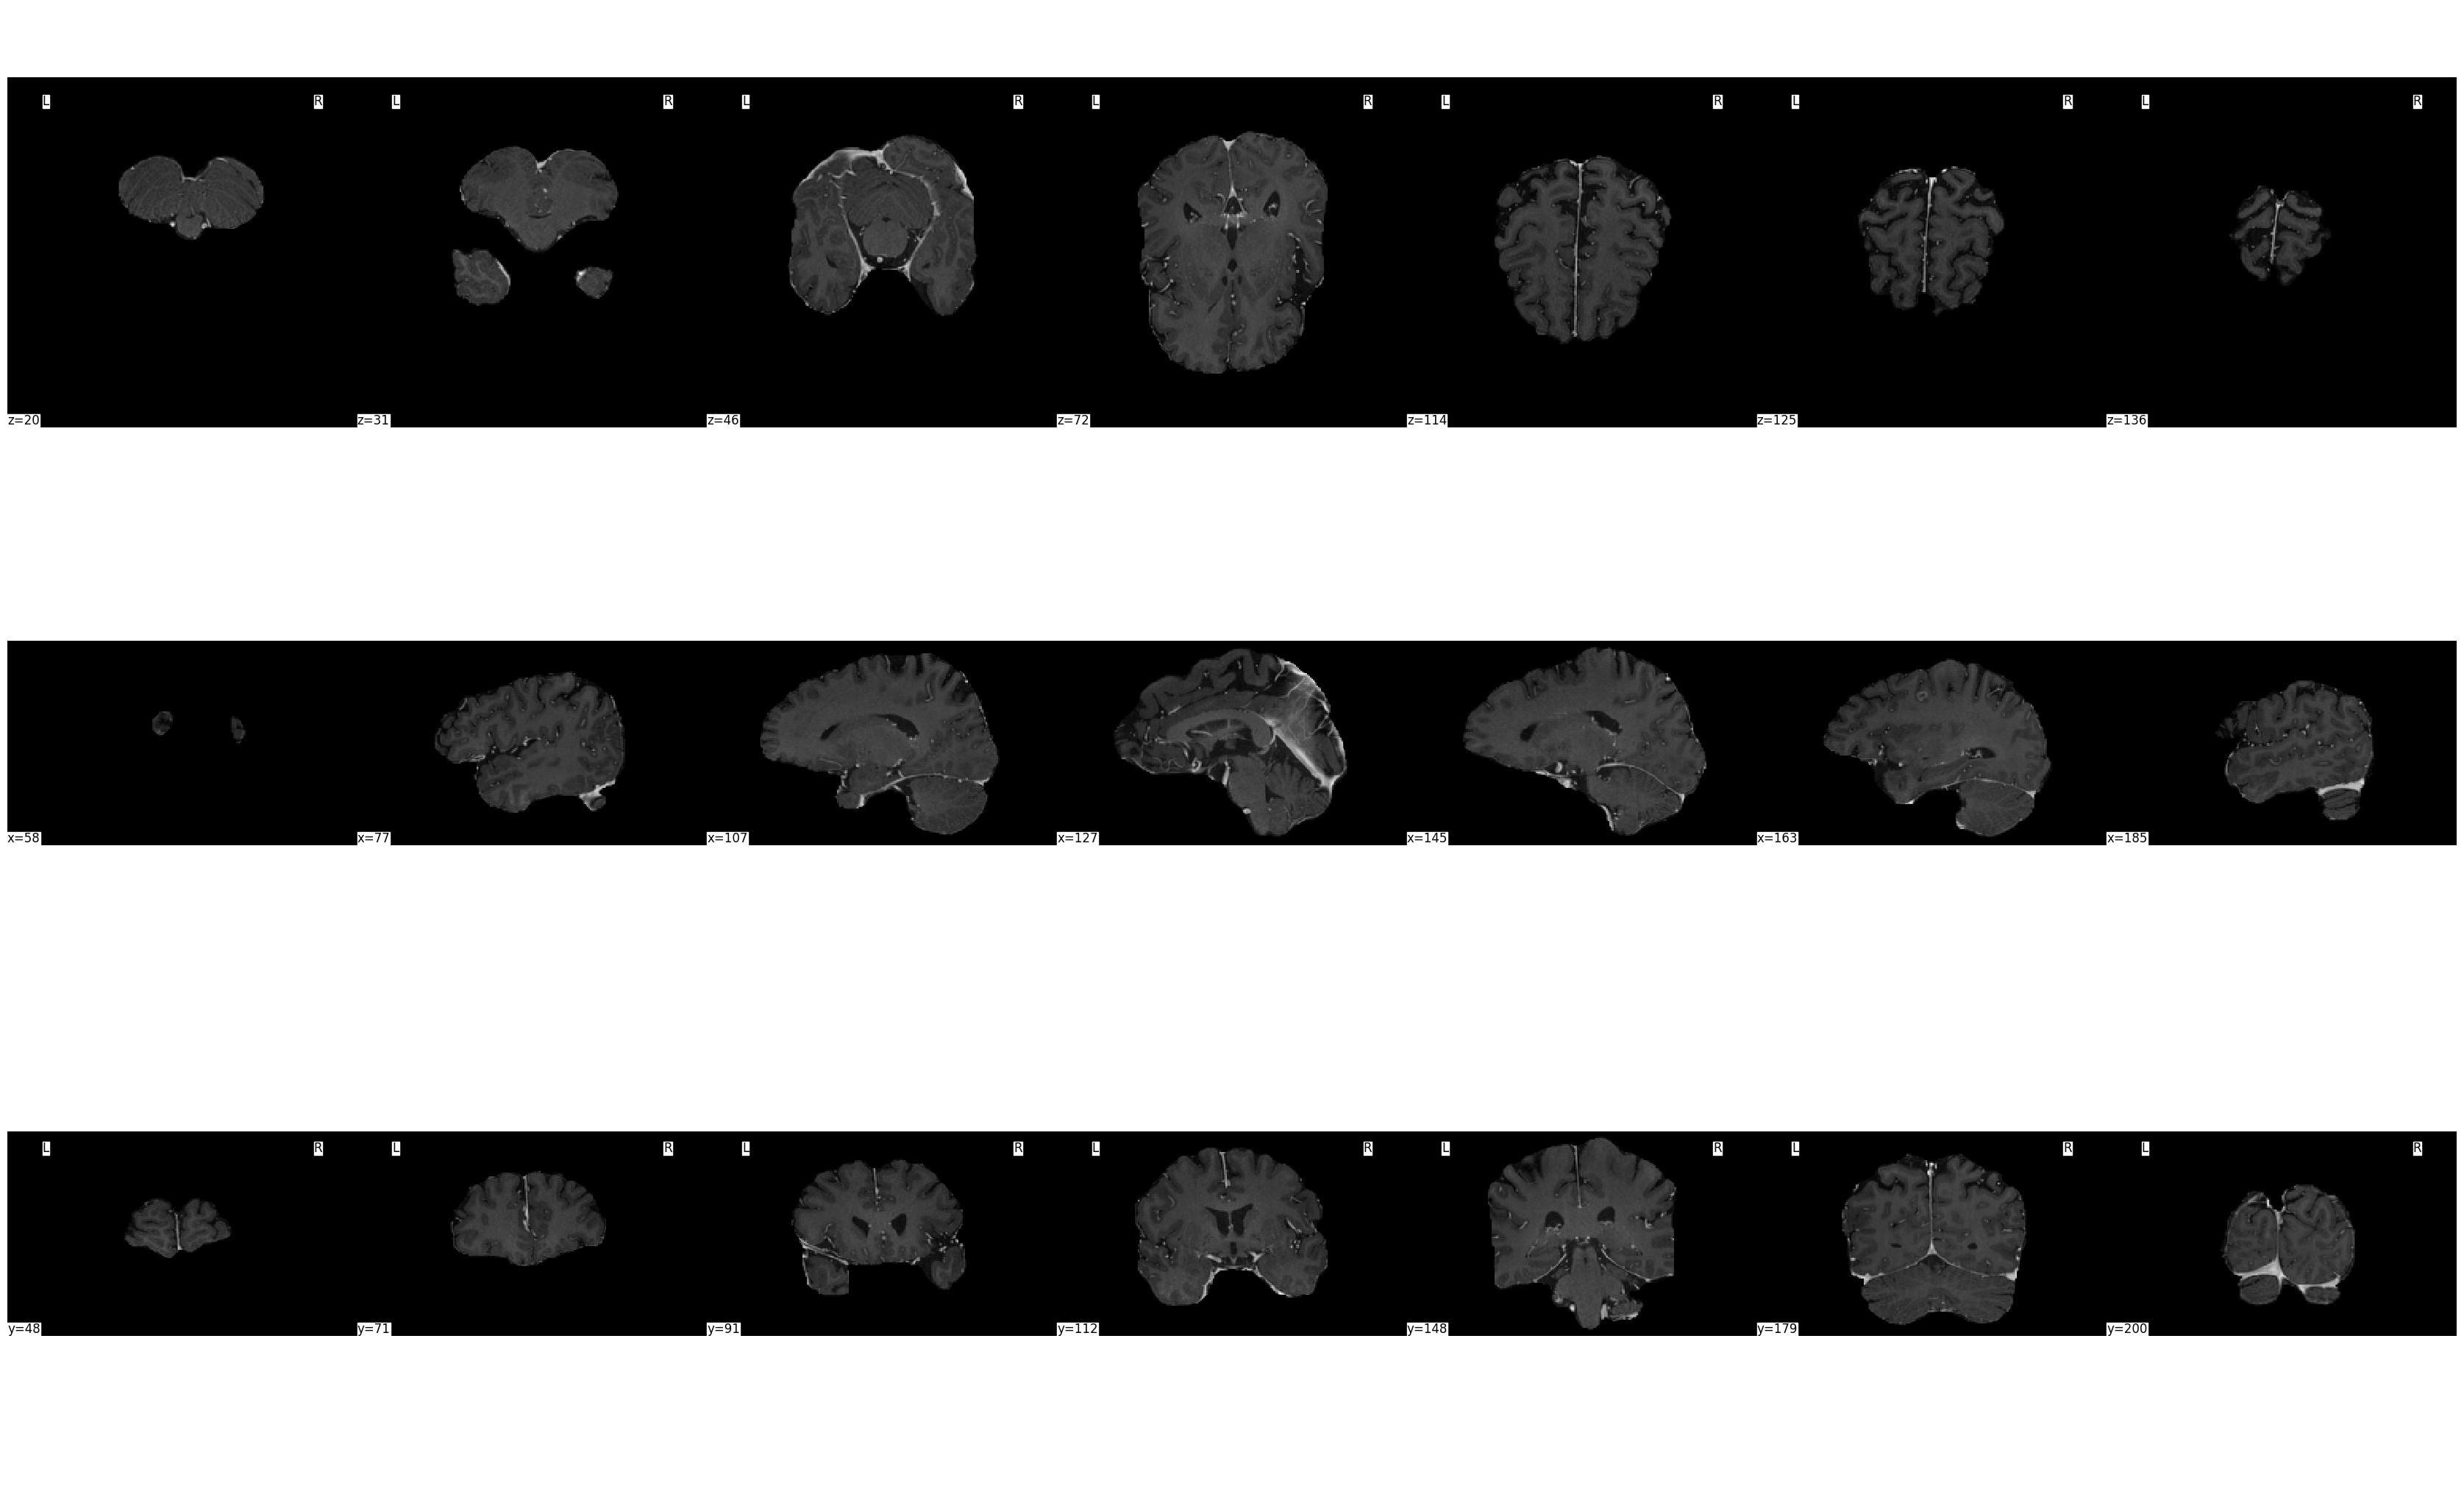

In [9]:
# plot bravo image of subject
nii_img = nib.load(train_ds.imgs[subj_idx]['bravo'])
plotting.plot_img(nii_img, display_mode='mosaic', cmap='gray')
plt.show()

In [10]:
nii_img.shape

(256, 256, 150)

In [12]:
print(nii_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.     0.9375 0.9375 1.     1.     1.     1.     1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0